# AudioCLIP Demo

Authored by [Andrey Guzhov](https://github.com/AndreyGuzhov)

This notebook covers common use cases of AudioCLIP and provides the typical workflow.
Below, you will find information on:

0. [Binary Assets](#Downloading-Binary-Assets)
1. [Required imports](#Imports-&-Constants)
2. [Model Instantiation](#Model-Instantiation)
3. [Data Transformation](#Audio-&-Image-Transforms)
4. Data Loading
    * [Audio](#Audio-Loading)
    * [Images](#Image-Loading)
5. [Preparation of the Input](#Input-Preparation)
6. [Acquisition of the Output](#Obtaining-Embeddings)
7. [Normalization of Embeddings](#Normalization-of-Embeddings)
8. [Calculation of Logit Scales](#Obtaining-Logit-Scales)
9. [Computation of Similarities](#Computing-Similarities)
10. Performing Tasks
    1. [Classification](#Classification)
        1. [Audio](#Audio)
        2. [Images](#Images)
    2. [Querying](#Querying)
        1. [Audio by Text](#Audio-by-Text)
        2. [Images by Text](#Images-by-Text)
        3. [Audio by Images](#Audio-by-Images)
        4. [Images by Audio](#Images-by-Audio)

## Downloading Binary Assets

In [20]:
# ! wget -P ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz
# ! wget -P ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt

## Imports & Constants

In [1]:
import os
import sys
import glob

import librosa
import librosa.display

import simplejpeg
import numpy as np

import torch
import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

from model import AudioCLIP
from utils.transforms import ToTensor1D, RandomFlip, RandomScale, RandomPadding, RandomCrop, RandomNoise


torch.set_grad_enabled(False)

# MODEL_FILENAME = 'AudioCLIP-FineTuneImage-AudioTransform.pt'
MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

LABELS = ['cat', 'thunderstorm', 'coughing', 'alarm clock', 'car horn', 'cow bell', 'sad', 'happy', 'romance', 'manga', 'action']

## Model Instantiation

In [2]:
aclp = AudioCLIP(pretrained=f'./assets/{MODEL_FILENAME}')
# aclp = AudioCLIP()

## Audio & Image Transforms

In [3]:
device = 'cuda:3'
# aclp.to(device)

In [4]:
audio_transforms = tv.transforms.Compose([
    ToTensor1D(),
    RandomFlip(p=0.5), 
    RandomScale(max_scale=1.5), 
    RandomPadding(out_len=220500), 
    RandomCrop(out_len=220500), 
    RandomNoise(snr_max_db=120.0, snr_min_db=10.0, p=0.25)
])

audio_transforms_test = tv.transforms.Compose([
    ToTensor1D(),
    RandomPadding(out_len=220500), 
    RandomCrop(out_len=220500), 
])


image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

/home/megha/.pyenv/versions/3.8.10/envs/audioclip/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Audio Downloading
Audio samples are drawn from the **AudioSet** dataset.

In [ ]:

# data_path = '../../audioset-processing/music mood/'
# moods = ['Angry music', 'Exciting music', 'Funny music', 'Happy music', 'Sad music', 'Scary music', 'Tender music']

# moods_audio = {}
# for mood in moods:
#     paths_to_audio = glob.glob(data_path + mood + '/*.wav')
#     audio = list()
#     for path_to_audio in paths_to_audio:
#         track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)
#         track = librosa.util.fix_length(track, size=220500)

#         # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
#         # thus, the actual time-frequency representation will be visualized
#         spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
#         spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
#         pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

#         audio.append((track, pow_spec))
#     moods_audio[mood] = audio

In [ ]:
# data_path_npz = '../../audioset-processing/music mood npz/'

# for mood, audios in moods_audio.items():
#     for i, (track, pow_spec) in enumerate(audios):
#         path_to_audio = data_path_npz + mood + '/' + str(i) + '.npz'
#         with open(path_to_audio, 'wb') as f:
#             np.save(f, track)
#             np.save(f, pow_spec)

## Audio Loading
Audio samples are drawn from the **AudioSet** dataset.

In [5]:
data_path_npz = '../audioset-processing/music mood npz/'
moods = ['Angry music', 'Exciting music', 'Funny music', 'Happy music', 'Sad music', 'Scary music', 'Tender music']

moods_audio = {}

for mood in moods:
    paths_to_audio = glob.glob(data_path_npz + mood + '/*.npz')
    audio = list()
    # print(paths_to_audio)
    for path_to_audio in paths_to_audio:
        # print(path_to_audio)
        with open(path_to_audio, 'rb') as f:
            # print('hellp')//
            track = np.load(f)
            pow_spec = np.load(f)

        audio.append((track, pow_spec))
    moods_audio[mood] = audio

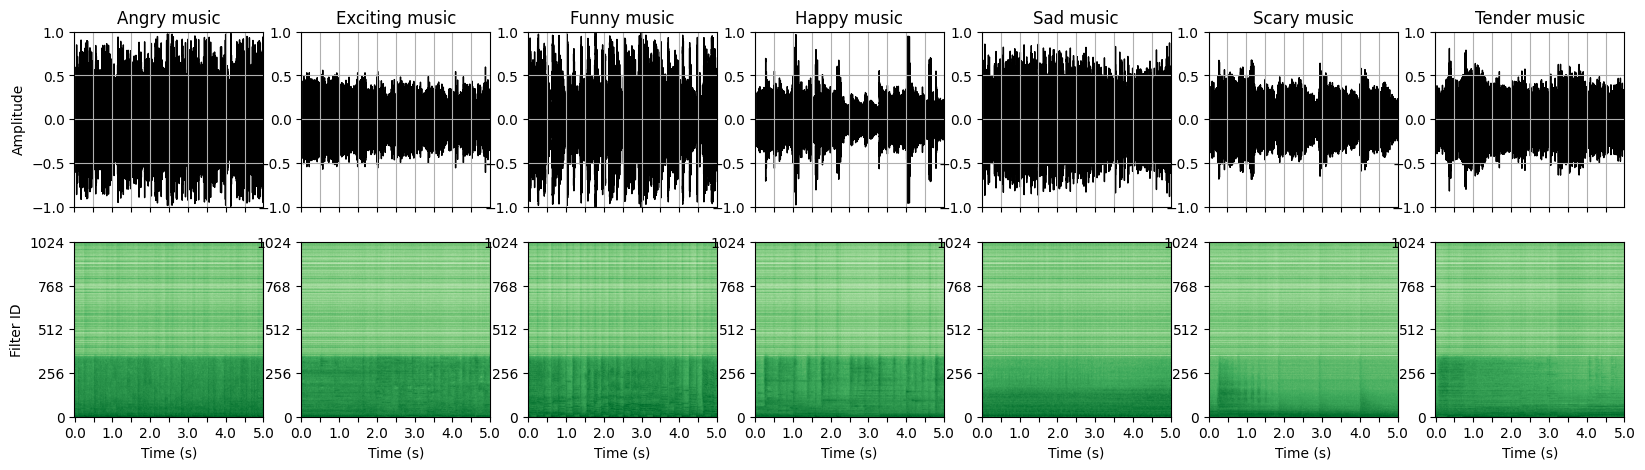

In [ ]:
fig, axes = plt.subplots(2, len(moods), figsize=(20, 5), dpi=100)

for idx, mood in enumerate(moods):
    audio = moods_audio[mood]
    # idx = i
    track, pow_spec = audio[idx]

    # draw the waveform
    librosa.display.waveplot(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
    # show the correspondin power spectrogram
    axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='Greens', vmin=-180.0, vmax=20.0)

    # modify legend
    axes[0, idx].set_title(mood)
    axes[0, idx].set_xlabel('')
    axes[0, idx].set_xticklabels([])
    axes[0, idx].grid(True)
    axes[0, idx].set_ylim(bottom=-1, top=1)

    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
    axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
    axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

axes[0, 0].set_ylabel('Amplitude')
axes[1, 0].set_ylabel('Filter ID')

plt.show()
plt.close(fig)

# for idx, path in enumerate(paths_to_audio):
#     print(os.path.basename(path))
#     display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))

## Audio Loading (Eval)

In [90]:
paths_to_audio = glob.glob('./demo/audio_finetune/*.wav')
moods = ['Angry music', 'Exciting music', 'Funny music', 'Happy music', 'Sad music', 'Scary music', 'Tender music']
aclp.to('cpu')
audio = list()
for path_to_audio in paths_to_audio:
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)
    track = librosa.util.fix_length(track, size=220500)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
    spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, pow_spec))

## Image Loading

In [6]:
import pandas as pd
from tqdm import tqdm

metadata_path = '../../../data/11/megha/mangadataset/Manga109_released_2021_12_30/manga109metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata.head()

,NUMBER,JAPANESE_NAME,ENGLISH_NAME,AUTHOR,TIME,PUBLISHER,AUDIENCE,GENRE,PAGES,VOLUMES,MANGA_S
0,1,1・2・3でキメてあげる,Count3DeKimeteAgeru,Omiya Naoi,1980's,Kadokawa Shoten Publishing,boy,sports,198,1.0,✔
1,2,愛さずにはいられない,AisazuNihaIrarenai,Yoshi Masako,1980's,Shueisha,girl,love romance,187,2.0,✔
2,3,あっけら貫刃帖,AkkeraKanjinchou,Kobayashi Yuki,2000's,Shueisha,boy,battle,183,1.0,✔
3,4,あくはむ,Akuhamu,Arai Satoshi,2000's,Kodansha,boy,four-frame cartoons,161,1.0,✔
4,5,青すぎる春,AosugiruHaru,Okuda Momoko,2000's,Shueisha,lady,love romance,210,NaN,✔


In [7]:
data_path_npz = '../../../data/11/megha/mangadataset/Manga109_released_2021_12_30/images npz/'
books_to_genre = pd.Series(metadata.GENRE.values,index=metadata.ENGLISH_NAME).to_dict()

genre_images = {}

genres = list(set(books_to_genre.values()))


for genre in books_to_genre.values():
    genre_images[genre] = []


for book in tqdm(books_to_genre.keys()):
    paths_to_images = glob.glob(data_path_npz + book + '/*.npz')
    images = list()
    genre = books_to_genre[book]

    for path_to_image in paths_to_images:
        # print(path_to_audio)
        with open(path_to_image, 'rb') as f:
            # print('hellp')//
            image = np.load(f)

        images.append(image)
    genre_images[genre].extend(images)

100%|██████████| 104/104 [00:25<00:00,  4.11it/s]


## Image Loading (Eval)

In [84]:
import pandas as pd
from tqdm import tqdm

metadata_path = '../../../data/11/megha/mangadataset/Manga109_released_2021_12_30/manga109metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata.head()

,NUMBER,JAPANESE_NAME,ENGLISH_NAME,AUTHOR,TIME,PUBLISHER,AUDIENCE,GENRE,PAGES,VOLUMES,MANGA_S
0,1,1・2・3でキメてあげる,Count3DeKimeteAgeru,Omiya Naoi,1980's,Kadokawa Shoten Publishing,boy,sports,198,1.0,✔
1,2,愛さずにはいられない,AisazuNihaIrarenai,Yoshi Masako,1980's,Shueisha,girl,love romance,187,2.0,✔
2,3,あっけら貫刃帖,AkkeraKanjinchou,Kobayashi Yuki,2000's,Shueisha,boy,battle,183,1.0,✔
3,4,あくはむ,Akuhamu,Arai Satoshi,2000's,Kodansha,boy,four-frame cartoons,161,1.0,✔
4,5,青すぎる春,AosugiruHaru,Okuda Momoko,2000's,Shueisha,lady,love romance,210,NaN,✔


In [85]:
names = []

# A book for every genre
genres_to_books = pd.Series(metadata.ENGLISH_NAME.values,index=metadata.GENRE).to_dict()

genres = list(set(genres_to_books.keys()))

# images_list = list()
genre_images = {}
for genre, book in tqdm(genres_to_books.items()):
    paths_to_images = glob.glob(data_path_npz + book + '/*.npz')
    # images = list()
    # genre = books_to_genre[book]

    for path_to_image in paths_to_images:
        # print(path_to_audio)
        with open(path_to_image, 'rb') as f:
            # print('hellp')//
            image = np.load(f)

        # images_list.append(image)
        break
    genre_images[genre] = image

# genre_images
images = list(genre_images.values())
genres = list(genre_images.keys())








100%|██████████| 12/12 [00:00<00:00, 306.00it/s]


In [ ]:
# paths_to_images = glob.glob('images/*.jpg')

# images = list()
# for path_to_image in paths_to_images:
#     with open(path_to_image, 'rb') as jpg:
#         image = simplejpeg.decode_jpeg(jpg.read())
#         images.append(image)

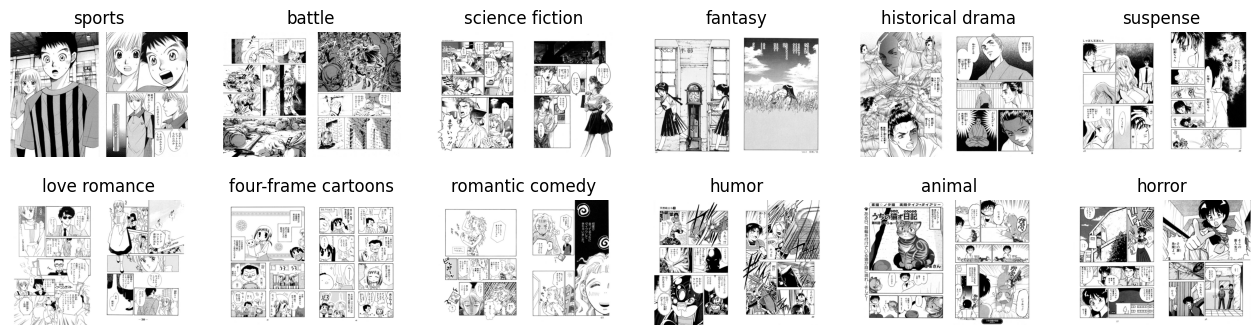

In [86]:
fig, axes = plt.subplots(2, len(images) // 2, figsize=(16, 4), dpi=100)

for idx, jdx in np.ndindex(axes.shape):
    # re-arrange order to show the images column-wise
    image_idx = np.ravel_multi_index(((jdx,), (idx,)), axes.shape[::-1]).item()
    axes[idx, jdx].imshow(images[image_idx])

    # modify legend
    axes[idx, jdx].axis('off')
    axes[idx, jdx].set_title(genres[image_idx])

plt.show()
plt.close(fig)

## Input Preparation

In [87]:
moods

['Angry music',
 'Exciting music',
 'Funny music',
 'Happy music',
 'Sad music',
 'Scary music',
 'Tender music']

In [91]:
# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
# mood = moods[0]
audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
# standard channel-first shape [batch x channels x height x width]
images = torch.stack([image_transforms(image) for image in images])
# textual input is processed internally, so no need to transform it beforehand
LABELS = moods + genres
text = [[label] for label in LABELS]
text


[['Angry music'],
 ['Exciting music'],
 ['Funny music'],
 ['Happy music'],
 ['Sad music'],
 ['Scary music'],
 ['Tender music'],
 ['sports'],
 ['love romance'],
 ['battle'],
 ['four-frame cartoons'],
 ['science fiction'],
 ['romantic comedy'],
 ['fantasy'],
 ['humor'],
 ['historical drama'],
 ['animal'],
 ['suspense'],
 ['horror']]

## Obtaining Embeddings
For the sake of clarity, all three modalities are processed separately.

In [92]:
# AudioCLIP's output: Tuple[Tuple[Features, Logits], Loss]
# Features = Tuple[AudioFeatures, ImageFeatures, TextFeatures]
# Logits = Tuple[AudioImageLogits, AudioTextLogits, ImageTextLogits]
aclp.eval()
((audio_features, _, _), _), _ = aclp(audio=audio)
((_, image_features, _), _), _ = aclp(image=images)
((_, _, text_features), _), _ = aclp(text=text)

## Normalization of Embeddings
The AudioCLIP's output is normalized using L<sub>2</sub>-norm

In [93]:
audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)

## Obtaining Logit Scales
Outputs of the text-, image- and audio-heads are made consistent using dedicated scaling terms for each pair of modalities.
The scaling factors are clamped between 1.0 and 100.0.

In [94]:
scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

## Computing Similarities
Similarities between different representations of a same concept are computed using [scaled](#Obtaining-Logit-Scales) dot product (cosine similarity).

In [95]:
logits_audio_image = scale_audio_image * audio_features @ image_features.T
logits_audio_text = scale_audio_text * audio_features @ text_features.T
logits_image_text = scale_image_text * image_features @ text_features.T

## Classification
This task is a specific case of a more general one, which is [querying](#Querying).
However, this setup is mentioned as a standalone because it demonstrates clearly how to perform usual classification (including [zero-shot inference](https://github.com/openai/CLIP#zero-shot-prediction)) using AudioCLIP.

### Audio

In [96]:
print('\t\tFilename, Audio\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Filename, Audio			Textual Label (Confidence)

      Scaru-_BMNBQy0XA_210.wav ->		         horror (97.07%), science fiction (02.92%),     Scary music (00.00%)
    Exciting-_UQq7BCpRk_30.wav ->		historical drama (98.46%), four-frame cartoons (00.80%),          battle (00.52%)
       Happy--CZ-8vrQ1g_30.wav ->		science fiction (68.26%), four-frame cartoons (23.00%),    love romance (04.69%)
      Angry-3kcEeGAgSg_230.wav ->		romantic comedy (100.00%),        suspense (00.00%),         fantasy (00.00%)
        sad_--ip67RoGwo_30.wav ->		         animal (75.69%),          horror (23.62%),    love romance (00.29%)
       Funny-0tUgm2_vRc_30.wav ->		science fiction (56.59%), four-frame cartoons (40.14%),           humor (00.83%)
      Tender-_d175JBNUw_30.wav ->		         horror (100.00%), science fiction (00.00%),          animal (00.00%)


### Images

In [97]:
print('\tFilename, Image\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=1)
for image_idx in range(len(images)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[image_idx].topk(3)

    # format output strings
    query = f'{genres[image_idx]:>20s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>20s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Filename, Image			Textual Label (Confidence)

              sports ->		              sports (99.38%),         love romance (00.10%),         Tender music (00.05%)
        love romance ->		        love romance (93.63%),               horror (01.49%),          Happy music (00.63%)
              battle ->		             fantasy (85.06%),      science fiction (04.07%),               battle (02.18%)
 four-frame cartoons ->		 four-frame cartoons (99.64%),               animal (00.23%),         love romance (00.04%)
     science fiction ->		     science fiction (94.47%),          Funny music (00.72%),               animal (00.62%)
     romantic comedy ->		     romantic comedy (87.77%),               animal (02.69%),         love romance (02.05%)
             fantasy ->		             fantasy (91.37%),               battle (04.95%),             suspense (00.80%)
               humor ->		               humor (98.91%),               battle (00.19%),               animal (00.12%)
    historical dr

## Querying

### Audio by Text

In [98]:
print('\t\tTextual Label\t\tFilename, Audio (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, label_idx].topk(2)

    # format output strings
    query = f'{LABELS[label_idx]:>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Textual Label		Filename, Audio (Confidence)

              Angry music ->		      Angry-3kcEeGAgSg_230.wav (66.95%),         sad_--ip67RoGwo_30.wav (10.56%)
           Exciting music ->		    Exciting-_UQq7BCpRk_30.wav (24.72%),        Happy--CZ-8vrQ1g_30.wav (15.45%)
              Funny music ->		      Scaru-_BMNBQy0XA_210.wav (27.13%),        Happy--CZ-8vrQ1g_30.wav (23.19%)
              Happy music ->		      Tender-_d175JBNUw_30.wav (20.82%),        Happy--CZ-8vrQ1g_30.wav (19.91%)
                Sad music ->		      Tender-_d175JBNUw_30.wav (23.52%),       Scaru-_BMNBQy0XA_210.wav (21.28%)
              Scary music ->		      Scaru-_BMNBQy0XA_210.wav (31.68%),       Tender-_d175JBNUw_30.wav (24.79%)
             Tender music ->		        sad_--ip67RoGwo_30.wav (30.96%),       Angry-3kcEeGAgSg_230.wav (25.61%)
                   sports ->		        sad_--ip67RoGwo_30.wav (52.69%),     Exciting-_UQq7BCpRk_30.wav (22.08%)
             love romance ->		        sad_--ip67RoGwo_30.wav (67.

### Images by Text

In [111]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[:, label_idx].topk(3)

    # format output strings
    query = f'{LABELS[label_idx]:>20s} ->\t\t'
    results = ', '.join([f'{genres[i]:>20s} ({v:>06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

         Angry music ->		     romantic comedy (32.26%),         love romance (20.31%),     historical drama (14.29%)
      Exciting music ->		    historical drama (31.33%),         love romance (21.59%),      romantic comedy (13.86%)
         Funny music ->		        love romance (22.34%),     historical drama (18.47%),      romantic comedy (16.24%)
         Happy music ->		        love romance (27.48%),     historical drama (18.88%),      romantic comedy (15.87%)
           Sad music ->		        love romance (25.01%),     historical drama (24.80%),      romantic comedy (14.86%)
         Scary music ->		        love romance (22.84%),     historical drama (21.01%),      romantic comedy (15.67%)
        Tender music ->		     romantic comedy (25.88%),         love romance (23.51%),     historical drama (13.51%)
              sports ->		              sports (94.91%),     historical drama (03.82%),      romantic comedy (00.44%)
        love roma

### Audio by Images

In [108]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=0)
for image_idx in range(len(images)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, image_idx].topk(2)

    # format output strings
    query = f'{genres[image_idx]:>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

                   sports ->		        sad_--ip67RoGwo_30.wav (99.31%),       Tender-_d175JBNUw_30.wav (00.42%)
             love romance ->		        sad_--ip67RoGwo_30.wav (85.31%),        Happy--CZ-8vrQ1g_30.wav (10.94%)
                   battle ->		      Scaru-_BMNBQy0XA_210.wav (54.04%),       Tender-_d175JBNUw_30.wav (41.65%)
      four-frame cartoons ->		       Happy--CZ-8vrQ1g_30.wav (61.17%),        Funny-0tUgm2_vRc_30.wav (38.49%)
          science fiction ->		      Scaru-_BMNBQy0XA_210.wav (99.94%),       Tender-_d175JBNUw_30.wav (00.06%)
          romantic comedy ->		      Angry-3kcEeGAgSg_230.wav (100.00%),         sad_--ip67RoGwo_30.wav (00.00%)
                  fantasy ->		      Angry-3kcEeGAgSg_230.wav (90.70%),         sad_--ip67RoGwo_30.wav (07.91%)
                    humor ->		       Happy--CZ-8vrQ1g_30.wav (63.16%),        Funny-0tUgm2_vRc_30.wav (34.82%)
         historical drama ->		    Exciting-_UQq7BCpRk_30.wav (10

### Images by Audio

In [113]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{genres[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

      Scaru-_BMNBQy0XA_210.wav ->		science fiction (99.98%),          horror (00.02%),          battle (00.00%)
    Exciting-_UQq7BCpRk_30.wav ->		historical drama (100.00%), four-frame cartoons (00.00%),    love romance (00.00%)
       Happy--CZ-8vrQ1g_30.wav ->		four-frame cartoons (81.78%), science fiction (17.07%),           humor (00.50%)
      Angry-3kcEeGAgSg_230.wav ->		romantic comedy (100.00%),         fantasy (00.00%), science fiction (00.00%)
        sad_--ip67RoGwo_30.wav ->		         animal (99.94%),        suspense (00.02%),    love romance (00.02%)
       Funny-0tUgm2_vRc_30.wav ->		four-frame cartoons (83.40%), science fiction (15.98%),           humor (00.44%)
      Tender-_d175JBNUw_30.wav ->		         horror (64.08%), science fiction (35.40%),          animal (00.42%)


# Finetuning on AudioSet

In [23]:
import gc
gc.collect()

471

In [8]:
# Latest Update : 18 July 2022, 09:55 GMT+7

# TO ADD :
# Gradient Checkpointing
# Filter out bias from weight decay
# Decaying learning rate with cosine schedule
# Half-precision Adam statistics
# Half-precision stochastically rounded text encoder weights were used

#BATCH_SIZE must larger than 1

# device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
# model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
# audio_angry = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in moods_audio[mood]])
# # standard channel-first shape [batch x channels x height x width]
# # images = torch.stack([image_transforms(image) for image in images])
# # textual input is processed internally, so no need to transform it beforehand
# LABELS = moods
# text = [[label] for label in LABELS]
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split


BATCH_SIZE = 32
EPOCH = 50

# Flattened tracks
audios = []
labels = []

for mood, tracks in moods_audio.items():
    for track, _  in tracks:
        audios.append(track)
        labels.append(mood)

train_indices, val_indices = train_test_split(list(range(len(labels))), test_size=0.2, stratify=labels)



class train_audio_title_dataset(Dataset):
    def __init__(self, audios, labels, indices):

        self.audios = []
        self.labels = []

        for i in indices:
            self.audios.append(audios[i])
            self.labels.append(labels[i])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        # title = self.title[idx]
        audio = audio_transforms(self.audios[idx].reshape(1, -1))
        label = [self.labels[idx]]
        return audio, label
    
class test_audio_title_dataset(Dataset):
    def __init__(self, audios, labels, indices):

        self.audios = []
        self.labels = []

        for i in indices:
            self.audios.append(audios[i])
            self.labels.append(labels[i])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        # title = self.title[idx]
        audio = audio_transforms_test(self.audios[idx].reshape(1, -1))
        label = [self.labels[idx]]
        return audio, label


# use your own data
# list_image_path = ['folder/image1.jpg','folder2/image2.jpg'] 
# list_txt = ['description for image1.jpg' , 'description for image2.jpg']
# dataset = audio_title_dataset(moods_audio)
# train_len = int(len(dataset) * 0.7)
# val_len = int(len(dataset) * 0.3)
# test_len = len(dataset) - train_len - val_len
# train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

train_set = train_audio_title_dataset(audios, labels, train_indices)
val_set = train_audio_title_dataset(audios, labels, val_indices)


train_dataloader = DataLoader(train_set,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader
val_dataloader = DataLoader(val_set,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader


#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


# disable all parameters
for p in aclp.parameters():
    p.requires_grad = False

# enable only audio-related parameters
for p in aclp.audio.parameters():
    p.requires_grad = True

# disable fbsp-parameters
for p in aclp.audio.fbsp.parameters():
    p.requires_grad = False

# disable logit scaling
aclp.logit_scale_ai.requires_grad = False
aclp.logit_scale_at.requires_grad = False

# add only enabled parameters to optimizer's list
param_groups = [
    {'params': [p for p in aclp.parameters() if p.requires_grad]}
]

# enable fbsp-parameters
for p in aclp.audio.fbsp.parameters():
    p.requires_grad = True

# enable logit scaling
aclp.logit_scale_ai.requires_grad = True
aclp.logit_scale_at.requires_grad = True
# add fbsp- and logit scaling parameters to a separate group without weight decay
param_groups.append({
    'params': [
        p for p in aclp.audio.fbsp.parameters()
    ] + [
        aclp.logit_scale_ai,
        aclp.logit_scale_at
    ],
    'weight_decay': 0.0
})
optimizer = optim.SGD(param_groups, momentum=0.9, nesterov = True, weight_decay=5e-4, lr=5e-5) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [25]:
torch.set_grad_enabled(mode=True)
torch.is_grad_enabled()

True

In [26]:
for batch in train_dataloader:
    audios,texts = batch
    texts = [[text] for text in texts[0]] 
    print(texts)
    break

[['Exciting music'], ['Exciting music'], ['Funny music'], ['Tender music'], ['Angry music'], ['Exciting music'], ['Funny music'], ['Tender music'], ['Tender music'], ['Tender music'], ['Tender music'], ['Exciting music'], ['Tender music'], ['Happy music'], ['Exciting music'], ['Exciting music'], ['Angry music'], ['Tender music'], ['Exciting music'], ['Angry music'], ['Exciting music'], ['Tender music'], ['Exciting music'], ['Happy music'], ['Exciting music'], ['Exciting music'], ['Tender music'], ['Angry music'], ['Sad music'], ['Tender music'], ['Tender music'], ['Scary music']]


In [ ]:
from torch.autograd import Variable
from tqdm import tqdm


loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# add your own code to track the training progress.
device = "cuda:3"
aclp.to(device)
# aclp.train()
best_loss = 6.25
# 4.1667847656397425 all BS=8
# 8.06 -> 7.250161148252941 audio transform BS = 64
# 6.25 BS = 32

for epoch in tqdm(range(EPOCH)):
  train_losses = 0.0
  train_batches = 0
#   aclp.train()
  for batch in train_dataloader :
      train_batches +=1
      optimizer.zero_grad()

      audios,texts = batch 
    
      audios= audios.to(device)
      texts = [[text] for text in texts[0]] 
      # texts = texts.to(device)
    
      batch_indices = torch.arange(audios.shape[0], dtype=torch.int64, device=device)
      # logits_per_image, logits_per_text = model(images, texts)
      # with torch.grad
      _, loss = aclp(audio=audios, text=texts, batch_indices=batch_indices)

      # ground_truth = torch.arange(len(audios),dtype=torch.long, device=device)

      # loss = torch.tensor(0.0, device=device, requires_grad=True)
      # loss += (loss_img(logits_audio_text,ground_truth) + loss_txt(logits_audio_text.transpose(-1, -2),ground_truth))/2
      # total_loss = Variable(total_loss, requires_grad = True)
      # loss.retain_grad()
      
      loss.backward()
      train_losses += loss.item()
      optimizer.step()
      # if device == "cpu":
      #    optimizer.step()
      # else : 
      #   convert_models_to_fp32(aclp)
      #   optimizer.step()
        # clip.model.convert_weights(model)
  scheduler.step()

#   aclp.eval()
  val_losses = 0.0
  val_batches = 0
  for batch in val_dataloader:
     with torch.no_grad():
         val_batches +=1

         audios,texts = batch 
      
         audios= audios.to(device)
         texts = [[text] for text in texts[0]] 
      
         batch_indices = torch.arange(audios.shape[0], dtype=torch.int64, device=device)
         _, loss = aclp(audio=audios, text=texts, batch_indices=batch_indices)
         val_losses += loss.item()
     
  print("Training Epoch", epoch)
  print("Training Loss", train_losses/train_batches," Validation Loss", val_losses/val_batches)
  if best_loss == 0.0:
     print("Saved model!")
     best_loss = val_losses/val_batches
     torch.save(aclp.state_dict(), './assets/AudioCLIP-FineTuneImage-AudioTransform.pt')

  elif (val_losses/val_batches) < best_loss:
     best_loss = val_losses/val_batches
     print("Saved model!")
     torch.save(aclp.state_dict(), './assets/AudioCLIP-FineTuneImage-AudioTransform.pt')


In [ ]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(aclp.parameters(), lr=0.001, momentum=0.9)
def train_audio(audios, label, epochs = 10):
    aclp.train()
    audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audios])
    text = [[label] for i in range(len(audio))]
    for epoch in range(epochs):
        ((audio_features, _, text_features), (_, logits_audio_text, _)), loss = aclp(audio=audio, text=text)
        print(logits_audio_text.shape)
        print('  batch {} loss: {}'.format(epoch + 1, loss.item()))

        loss.backward()
        optimizer.step()
        # print(loss)

In [ ]:
import pandas as pd

data_path = '../../audioset-processing/output/'
column_names = ['ytid', 'Start', 'End', 'Tags']
moods = ['Angry music', 'Exciting music', 'Funny music', 'Happy music', 'Sad music', 'Scary music', 'Tender music']

moods_df = []
for mood in moods:
    df = pd.read_csv(data_path + mood + '.csv', names=column_names)
    moods_df.append(df)
# theme_music = pd.read_csv(data_path + 'theme music.csv', names=column_names)
# bg_music = pd.read_csv(data_path + 'background music.csv', names=column_names)

music_df = pd.concat(moods_df)
music_df

,ytid,Start,End,Tags
0,-3kcEeGAgSg,230,240,"/m/04rlf,/t/dd00036"
1,-4G_29Yl7P4,30,40,"/m/04rlf,/t/dd00036"
2,-5NIs-eePWI,30,40,/t/dd00036
3,-60D1x-whAU,170,180,"/m/04rlf,/t/dd00036"
4,-7QDWjiBoWs,30,40,"/m/04rlf,/t/dd00036"
...,...,...,...,...
2072,P5iPCnDkH3s,210,220,"/m/04rlf,/t/dd00034"
2073,P6cVJYT_i-c,30,40,"/m/016cjb,/m/04rlf,/t/dd00034"
2074,P8koh6JKaSs,30,40,"/m/04rlf,/t/dd00034"
2075,P9qT948r36M,30,40,"/m/0145m,/m/04rlf,/m/05rwpb,/t/dd00034"


In [ ]:
# get name of tags from ontology
ontology = pd.read_json('../../audioset-processing/ontology.json')
ontology.head()

,id,name,description,citation_uri,positive_examples,child_ids,restrictions
0,/m/0dgw9r,Human sounds,Sounds produced by the human body through the ...,,[],"[/m/09l8g, /m/01w250, /m/09hlz4, /m/0bpl036, /...",[abstract]
1,/m/09l8g,Human voice,The human voice consists of sound made by a hu...,http://en.wikipedia.org/wiki/Human_voice,[],"[/m/09x0r, /m/07p6fty, /m/03qc9zr, /m/02rtxlg,...",[abstract]
2,/m/09x0r,Speech,Speech is the vocalized form of human communic...,http://en.wikipedia.org/wiki/Speech,"[youtu.be/8uI9H5jGRV8?start=30&end=40, youtu.b...","[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",[]
3,/m/05zppz,"Male speech, man speaking",Speech uttered by an adult male human.,,"[youtu.be/6niRPYpLOpQ?start=30&end=40, youtu.b...",[],[]
4,/m/02zsn,"Female speech, woman speaking",Speech uttered by an adult female human.,,"[youtu.be/4l05nCOnIRg?start=30&end=40, youtu.b...",[],[]


In [ ]:
ids_to_names = dict(zip(ontology['id'], ontology['name']))
ids_to_names

{'/m/0dgw9r': 'Human sounds',
 '/m/09l8g': 'Human voice',
 '/m/09x0r': 'Speech',
 '/m/05zppz': 'Male speech, man speaking',
 '/m/02zsn': 'Female speech, woman speaking',
 '/m/0ytgt': 'Child speech, kid speaking',
 '/m/01h8n0': 'Conversation',
 '/m/02qldy': 'Narration, monologue',
 '/m/0261r1': 'Babbling',
 '/m/0brhx': 'Speech synthesizer',
 '/m/07p6fty': 'Shout',
 '/m/07q4ntr': 'Bellow',
 '/m/07rwj3x': 'Whoop',
 '/m/07sr1lc': 'Yell',
 '/m/04gy_2': 'Battle cry',
 '/t/dd00135': 'Children shouting',
 '/m/03qc9zr': 'Screaming',
 '/m/02rtxlg': 'Whispering',
 '/m/01j3sz': 'Laughter',
 '/t/dd00001': 'Baby laughter',
 '/m/07r660_': 'Giggle',
 '/m/07s04w4': 'Snicker',
 '/m/07sq110': 'Belly laugh',
 '/m/07rgt08': 'Chuckle, chortle',
 '/m/0463cq4': 'Crying, sobbing',
 '/t/dd00002': 'Baby cry, infant cry',
 '/m/07qz6j3': 'Whimper',
 '/m/07qw_06': 'Wail, moan',
 '/m/07plz5l': 'Sigh',
 '/m/015lz1': 'Singing',
 '/m/0l14jd': 'Choir',
 '/m/01swy6': 'Yodeling',
 '/m/02bk07': 'Chant',
 '/m/01c194': 'Mant

In [ ]:
music_df['Tag Names'] = music_df['Tags'].apply(lambda tags: [ids_to_names[tag] for tag in tags])
music_df.head()

,ytid,Start,End,Tags,Tag Names
0,-3kcEeGAgSg,230,240,"[/m/04rlf, /t/dd00036]","[Music, Angry music]"
1,-4G_29Yl7P4,30,40,"[/m/04rlf, /t/dd00036]","[Music, Angry music]"
2,-5NIs-eePWI,30,40,[/t/dd00036],[Angry music]
3,-60D1x-whAU,170,180,"[/m/04rlf, /t/dd00036]","[Music, Angry music]"
4,-7QDWjiBoWs,30,40,"[/m/04rlf, /t/dd00036]","[Music, Angry music]"


In [ ]:
# music caps
musiccaps = pd.read_csv(data_path + 'musiccaps-public.csv')
musiccaps.head()

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False


# Finetuning on Manga109

In [39]:
import gc
gc.collect()

1406

In [66]:
genre_images['sports'][0].shape

(1654, 3)

In [9]:
# Latest Update : 18 July 2022, 09:55 GMT+7

# TO ADD :
# Gradient Checkpointing
# Filter out bias from weight decay
# Decaying learning rate with cosine schedule
# Half-precision Adam statistics
# Half-precision stochastically rounded text encoder weights were used

#BATCH_SIZE must larger than 1

# device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
# model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
# audio_angry = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in moods_audio[mood]])
# # standard channel-first shape [batch x channels x height x width]
# # images = torch.stack([image_transforms(image) for image in images])
# # textual input is processed internally, so no need to transform it beforehand
# LABELS = moods
# text = [[label] for label in LABELS]
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from sklearn.metrics import accuracy_score
BATCH_SIZE = 64
EPOCH = 50

# Flattened tracks
images = []
labels = []

for genre, image in genre_images.items():
    for i in image:
        images.append(i)
        labels.append(genre)

train_indices, val_indices = train_test_split(list(range(len(labels))), test_size=0.2, stratify=labels)

class manga_genre_dataset(Dataset):
    def __init__(self, images, labels, indices):

        self.images = []
        self.labels = []

        for i in indices:
            self.images.append(images[i])
            self.labels.append(labels[i])
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio = image_transforms(self.images[idx])
        label = [self.labels[idx]]
        return audio, label

# use your own data
# list_image_path = ['folder/image1.jpg','folder2/image2.jpg'] 
# list_txt = ['description for image1.jpg' , 'description for image2.jpg']
# dataset = manga_genre_dataset(genre_images)
# train_len = int(len(dataset) * 0.8)
# val_len = int(len(dataset) * 0.2)
# test_len = len(dataset) - train_len - val_len
# train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])
trian_set = manga_genre_dataset(images, labels, train_indices)
val_set = manga_genre_dataset(images, labels, val_indices)


train_dataloader = DataLoader(train_set,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader
val_dataloader = DataLoader(val_set,batch_size = BATCH_SIZE, shuffle=True) #Define your own dataloader


#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


# enable all parameters
for p in aclp.parameters():
    p.requires_grad = True

# disable only audio-related parameters
for p in aclp.audio.parameters():
    p.requires_grad = False

# # disable fbsp-parameters
# for p in aclp.audio.fbsp.parameters():
#     p.requires_grad = False

# disable logit scaling
aclp.logit_scale_ai.requires_grad = False
aclp.logit_scale_at.requires_grad = False
# aclp.logit_scale_it.requires_grad = False


# add only enabled parameters to optimizer's list
param_groups = [
    {'params': [p for p in aclp.parameters() if p.requires_grad]}
]

# enable fbsp-parameters
# for p in aclp.audio.fbsp.parameters():
#     p.requires_grad = True

# enable logit scaling
# aclp.logit_scale_ai.requires_grad = True
# aclp.logit_scale_it.requires_grad = True
# # add fbsp- and logit scaling parameters to a separate group without weight decay
# param_groups.append({
#     'params': [
#         p for p in aclp.audio.fbsp.parameters()
#     ] + [
#         aclp.logit_scale_ai,
#         aclp.logit_scale_at
#     ]
# })
optimizer = optim.Adam(param_groups, betas=(0.9, 0.98), weight_decay=0.0001, eps=1e-6, lr=5e-5) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [10]:
from torch.autograd import Variable
from tqdm import tqdm

torch.set_grad_enabled(mode=True)
torch.is_grad_enabled()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# add your own code to track the training progress.
device = "cuda:3"
aclp.to(device)
# aclp.train()
best_loss = 4.447389174372919
# 4.415445705395071 image
# 4.1667847656397425 all BS=8
# 8.06 -> 7.250161148252941 audio transform BS = 64

for epoch in tqdm(range(EPOCH)):
  train_losses = 0.0
  train_batches = 0
#   aclp.train()
  for batch in train_dataloader :
      train_batches +=1
      optimizer.zero_grad()

      images,texts = batch 
    
      images= images.to(device)
      texts = [[text] for text in texts[0]] 
      # texts = texts.to(device)
    
      batch_indices = torch.arange(images.shape[0], dtype=torch.int64, device=device)
      # logits_per_image, logits_per_text = model(images, texts)
      # with torch.grad
      _, loss = aclp(image=images, text=texts, batch_indices=batch_indices)

      # ground_truth = torch.arange(len(audios),dtype=torch.long, device=device)

      # loss = torch.tensor(0.0, device=device, requires_grad=True)
      # loss += (loss_img(logits_audio_text,ground_truth) + loss_txt(logits_audio_text.transpose(-1, -2),ground_truth))/2
      # total_loss = Variable(total_loss, requires_grad = True)
      # loss.retain_grad()
      
      loss.backward()
      train_losses += loss.item()
      optimizer.step()
      # if device == "cpu":
      #    optimizer.step()
      # else : 
      #   convert_models_to_fp32(aclp)
      #   optimizer.step()
        # clip.model.convert_weights(model)
  scheduler.step()

#   aclp.eval()
  val_losses = 0.0
  val_batches = 0
  for batch in val_dataloader:
     with torch.no_grad():
        val_batches +=1

        images,texts = batch 
    
        images= images.to(device)
        texts = [[text] for text in texts[0]] 
        # texts = texts.to(device)
      
        batch_indices = torch.arange(images.shape[0], dtype=torch.int64, device=device)
        # logits_per_image, logits_per_text = model(images, texts)
        # with torch.grad
        _, loss = aclp(image=images, text=texts, batch_indices=batch_indices)
        val_losses += loss.item()
     
  print("Training Epoch", epoch)
  print("Training Loss", train_losses/train_batches," Validation Loss", val_losses/val_batches)
  if best_loss == 0.0:
     print("Saved model!")
     best_loss = val_losses/val_batches
     torch.save(aclp.state_dict(), './assets/AudioCLIP-FineTuneImage-AudioTransform.pt')

  elif (val_losses/val_batches) < best_loss:
     best_loss = val_losses/val_batches
     print("Saved model!")
     torch.save(aclp.state_dict(), './assets/AudioCLIP-FineTuneImage-AudioTransform.pt')



  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0
Training Loss 4.1586448909822575  Validation Loss 4.085500455671741
Saved model!


  4%|▍         | 2/50 [31:59<12:48:15, 960.32s/it]

Training Epoch 1
Training Loss 3.9604093476760487  Validation Loss 4.150828523501273


  6%|▌         | 3/50 [47:58<12:31:56, 959.93s/it]

Training Epoch 2
Training Loss 3.9636016699893415  Validation Loss 4.286037926712344


  8%|▊         | 4/50 [1:03:55<12:15:12, 958.96s/it]

Training Epoch 3
Training Loss 3.917803441197419  Validation Loss 4.193707882636978


 10%|█         | 5/50 [1:14:40<10:48:46, 865.02s/it]

Training Epoch 4
Training Loss 3.901544046796058  Validation Loss 4.332087394270685


 12%|█▏        | 6/50 [1:23:33<9:21:10, 765.25s/it] 

Training Epoch 5
Training Loss 3.8591154084717934  Validation Loss 4.347415426085072


 14%|█▍        | 7/50 [1:32:14<8:15:57, 692.03s/it]

Training Epoch 6
Training Loss 3.853267417466345  Validation Loss 4.349051741823073


 16%|█▌        | 8/50 [1:41:16<7:32:59, 647.13s/it]

Training Epoch 7
Training Loss 3.8213396633952117  Validation Loss 4.375453135644596


 18%|█▊        | 9/50 [1:50:09<6:58:42, 612.74s/it]

Training Epoch 8
Training Loss 3.833201278339733  Validation Loss 4.517211632382486


 20%|██        | 10/50 [1:58:58<6:31:39, 587.49s/it]

Training Epoch 9
Training Loss 3.8446238070480097  Validation Loss 4.564538471160397


 22%|██▏       | 11/50 [2:07:31<6:07:21, 565.16s/it]

Training Epoch 10
Training Loss 3.8173043550538623  Validation Loss 4.474260354234326


 24%|██▍       | 12/50 [2:16:27<5:52:27, 556.51s/it]

Training Epoch 11
Training Loss 3.825146334230407  Validation Loss 4.64743396753986


 26%|██▌       | 13/50 [2:25:21<5:38:58, 549.68s/it]

Training Epoch 12
Training Loss 3.8084807612679223  Validation Loss 4.562466433271766


 28%|██▊       | 14/50 [2:34:17<5:27:24, 545.68s/it]

Training Epoch 13
Training Loss 3.8089797693835803  Validation Loss 4.51939054073826


 30%|███       | 15/50 [2:43:10<5:16:08, 541.94s/it]

Training Epoch 14
Training Loss 3.797404722733931  Validation Loss 4.514186641862316


 32%|███▏      | 16/50 [2:51:59<5:04:49, 537.92s/it]

Training Epoch 15
Training Loss 3.784157027882978  Validation Loss 4.524791030754005


 34%|███▍      | 17/50 [3:01:05<4:57:13, 540.40s/it]

Training Epoch 16
Training Loss 3.7747786596786876  Validation Loss 4.610250665295508


 36%|███▌      | 18/50 [3:09:54<4:46:26, 537.07s/it]

Training Epoch 17
Training Loss 3.7694672454487193  Validation Loss 4.637781262397766


 38%|███▊      | 19/50 [3:18:58<4:38:29, 539.00s/it]

Training Epoch 18
Training Loss 3.7947263067418877  Validation Loss 4.5704168062056265


 40%|████      | 20/50 [3:28:08<4:31:10, 542.36s/it]

Training Epoch 19
Training Loss 3.76593189298614  Validation Loss 4.670476528906053


 42%|████▏     | 21/50 [3:36:46<4:18:39, 535.16s/it]

Training Epoch 20
Training Loss 3.763892162929882  Validation Loss 4.645021077125303


 44%|████▍     | 22/50 [3:45:23<4:07:09, 529.62s/it]

Training Epoch 21
Training Loss 3.7754071665204263  Validation Loss 4.523662214798312


 46%|████▌     | 23/50 [3:54:13<3:58:21, 529.70s/it]

Training Epoch 22
Training Loss 3.767238197247844  Validation Loss 4.699030345486056


 48%|████▊     | 24/50 [4:03:24<3:52:22, 536.24s/it]

Training Epoch 23
Training Loss 3.7558220211139397  Validation Loss 4.740739764705781


 50%|█████     | 25/50 [4:12:09<3:41:57, 532.71s/it]

Training Epoch 24
Training Loss 3.763013106732329  Validation Loss 4.70906080245491


 52%|█████▏    | 26/50 [4:21:11<3:34:12, 535.52s/it]

Training Epoch 25
Training Loss 3.7661565335328913  Validation Loss 4.658474089037026


 54%|█████▍    | 27/50 [4:30:06<3:25:12, 535.33s/it]

Training Epoch 26
Training Loss 3.7500290663774347  Validation Loss 4.607260396944419


 56%|█████▌    | 28/50 [4:39:01<3:16:19, 535.42s/it]

Training Epoch 27
Training Loss 3.753294022615291  Validation Loss 4.614152548774596


 58%|█████▊    | 29/50 [4:47:56<3:07:17, 535.11s/it]

Training Epoch 28
Training Loss 3.763658013225587  Validation Loss 4.600922502269367


# Testing on Manga109 and AudioSet

In [79]:
genres_to_idx = {k: v for v, k in enumerate(genres)}
genres_to_idx

{'historical drama': 0,
 'humor': 1,
 'animal': 2,
 'four-frame cartoons': 3,
 'fantasy': 4,
 'romantic comedy': 5,
 'suspense': 6,
 'science fiction': 7,
 'love romance': 8,
 'horror': 9,
 'sports': 10,
 'battle': 11}

In [ ]:
# Classification Accuracies
from tqdm import tqdm
from sklearn.metrics import accuracy_score

manga_acc = 0.0
LABELS = [[genre] for genre in genres]
manga_loader = val_dataloader
batches = 0
device='cuda:3'
aclp.to(device)
aclp.eval()

for batch in tqdm(manga_loader):
   batches += 1
   images, texts = batch
   batch_size = images.shape[0]

   images = images.to(device)
   # texts = [[text] for text in texts[0]] 
   # batch_indices = torch.arange(images.shape[0], dtype=torch.int64, device=device)
   # (_, (_,_,logits_image_text)), loss = aclp(image=images)
   # ((audio_features, _, _), _), _ = aclp(audio=audio)
   ((_, image_features, _), _), _ = aclp(image=images)
   ((_, _, text_features), _), _ = aclp(text=LABELS)

   # audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
   image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
   text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)
   # val_losses += loss.item()

   # scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
   # scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
   scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

   # logits_audio_image = scale_audio_image * audio_features @ image_features.T
   # logits_audio_text = scale_audio_text * audio_features @ text_features.T
   logits_image_text = scale_image_text * image_features @ text_features.T

   confidence = logits_image_text.softmax(dim=1)

   true_labels = [genres_to_idx[mood] for mood in texts[0]]
   pred_labels = [genres_to_idx[LABELS[confidence[i].topk(1)[1]][0]] for i in range(batch_size)]

   print(len(true_labels), len(pred_labels))

   acc = accuracy_score(true_labels, pred_labels)
   print(acc)


   # acc = 0
   # for i in range(batch_size):
   #    conf_values, id = confidence[i].topk(1)
   #    label = texts[0][i]
      
   #    if label == LABELS[id][0]:
   #       acc += 1
   #    else:
   #       print(label)
   #       print(LABELS[id])
   # acc = acc / batch_size
   # # print(acc)
   manga_acc += acc


manga_acc /= len(manga_loader)
# print()
print(manga_acc)
      

In [29]:
moods_to_idx = {k: v for v, k in enumerate(moods)}
moods_to_idx

{'Angry music': 0,
 'Exciting music': 1,
 'Funny music': 2,
 'Happy music': 3,
 'Sad music': 4,
 'Scary music': 5,
 'Tender music': 6}

In [22]:
# texts to one hot labels
# creating instance of one-hot-encoder

def text_to_onehotlabels(texts, LABELS):
    encodedlabels = np.zeros((len(texts), len(LABELS)), dtype='int')
    for i, label in enumerate(texts):
        temp = np.array([1 if label == LABELS[id] else 0 for id in range(len(LABELS))])
        encodedlabels[i] = temp

    return encodedlabels

    

In [31]:
# Classification Accuracies
from tqdm import tqdm
from sklearn import metrics

manga_acc = 0.0
LABELS = [[mood] for mood in moods]
manga_loader = val_dataloader
batches = 0
device='cuda:3'
aclp.to(device)
aclp.eval()

mAPs = []
for batch in tqdm(manga_loader):
   batches += 1
   audios, texts = batch
   batch_size = audios.shape[0]

   audios = audios.to(device)
   # texts = [[text] for text in texts[0]] 
   # batch_indices = torch.arange(images.shape[0], dtype=torch.int64, device=device)
   # (_, (_,_,logits_image_text)), loss = aclp(image=images)
   ((audio_features, _, _), _), _ = aclp(audio=audios)
   # ((_, image_features, _), _), _ = aclp(image=images)
   ((_, _, text_features), _), _ = aclp(text=LABELS)

   audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
   # image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
   text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)
   # val_losses += loss.item()

   # scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
   scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
   # scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

   # logits_audio_image = scale_audio_image * audio_features @ image_features.T
   logits_audio_text = scale_audio_text * audio_features @ text_features.T
   # logits_image_text = scale_image_text * image_features @ text_features.T

   confidence = logits_audio_text.softmax(dim=1).detach().cpu()
   target = text_to_onehotlabels(texts[0], moods)
   # target = [moods_to_idx[mood] for mood in texts[0]]
   # print(confidence)
   # print(target)


   avg_precisions = []
   for k in range(len(moods)):
      # Scikit-learn 0.22 cannot handle TP  = 0
      # https://stats.stackexchange.com/questions/503246/what-is-the-average-precision-in-the-case-of-no-positives-for-a-given-category-i
      # Hence we check it manually
      if 1 not in target[:, k]:
         avg_precision = 0
      elif 0 not in target[:, k]:
         avg_precision = 1
      else:
         avg_precision = metrics.average_precision_score(
            target[:, k], confidence[:, k], average=None)
      
      avg_precisions.append(avg_precision)
      # print(target[:,k])
      # print(confidence[:,k])
      # print(avg_precision)

   mAP = np.mean(avg_precisions)
   # print(mAP)
   mAPs.append(mAP)

   acc = 0
   for i in range(batch_size):
      conf_values, id = confidence[i].topk(1)
      label = texts[0][i]
      # print(label)
      # print(LABELS[id])
      if label == LABELS[id][0]:
         acc += 1
   acc = acc / batch_size
   # print(acc)
   manga_acc += acc


manga_acc /= len(manga_loader)
mAPs = np.mean(mAPs)
# print()
print(manga_acc)

100%|██████████| 42/42 [05:42<00:00,  8.17s/it]

0.5340544871794871


In [32]:
mAP

0.4276128633271491

# Querying on 200 samples

In [10]:
audio_queries = {}
image_queries = {}

for genre in genres:
   confidences = {}
   for mood in moods:
      confidences[mood] = []
   image_queries[genre] = confidences

for mood in moods:
   confidences = {}
   for genre in genres:
      confidences[genre] = []
   audio_queries[mood] = confidences

print(audio_queries)
print(image_queries)

{'Angry music': {'animal': [], 'science fiction': [], 'romantic comedy': [], 'horror': [], 'historical drama': [], 'fantasy': [], 'battle': [], 'four-frame cartoons': [], 'suspense': [], 'love romance': [], 'humor': [], 'sports': []}, 'Exciting music': {'animal': [], 'science fiction': [], 'romantic comedy': [], 'horror': [], 'historical drama': [], 'fantasy': [], 'battle': [], 'four-frame cartoons': [], 'suspense': [], 'love romance': [], 'humor': [], 'sports': []}, 'Funny music': {'animal': [], 'science fiction': [], 'romantic comedy': [], 'horror': [], 'historical drama': [], 'fantasy': [], 'battle': [], 'four-frame cartoons': [], 'suspense': [], 'love romance': [], 'humor': [], 'sports': []}, 'Happy music': {'animal': [], 'science fiction': [], 'romantic comedy': [], 'horror': [], 'historical drama': [], 'fantasy': [], 'battle': [], 'four-frame cartoons': [], 'suspense': [], 'love romance': [], 'humor': [], 'sports': []}, 'Sad music': {'animal': [], 'science fiction': [], 'romantic

In [11]:
# Classification Accuracies
from tqdm import tqdm
from sklearn import metrics

manga_acc = 0.0
LABELS = [[mood] for mood in moods] + [[genre] for genre in genres]
manga_loader = val_dataloader_manga
audio_loader = val_dataloader_audios
batches = 0
device='cuda:3'
aclp.to(device)
aclp.eval()

mAPs = []


for batch_manga, batch_audio in tqdm(zip(manga_loader, audio_loader)):

   batches += 1
   audios, texts_audios = batch_audio
   images, texts_manga = batch_manga

   batch_size = audios.shape[0]

   audios = audios.to(device)
   # texts = [[text] for text in texts[0]] 
   images = images.to(device)
   # batch_indices = torch.arange(images.shape[0], dtype=torch.int64, device=device)
   # (_, (_,_,logits_image_text)), loss = aclp(image=images)
   ((audio_features, _, _), _), _ = aclp(audio=audios)
   ((_, image_features, _), _), _ = aclp(image=images)
   ((_, _, text_features), _), _ = aclp(text=LABELS)

   audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
   image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
   text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)
   # val_losses += loss.item()

   scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
   scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
   scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

   logits_audio_image = scale_audio_image * audio_features @ image_features.T
   logits_audio_text = scale_audio_text * audio_features @ text_features.T
   logits_image_text = scale_image_text * image_features @ text_features.T

   #
   images_by_audio = logits_audio_image.softmax(dim=1).detach().cpu()
   audio_by_images = logits_audio_image.softmax(dim=0).detach().cpu()
   # target = text_to_onehotlabels(texts[0], moods)
   # target = [moods_to_idx[mood] for mood in texts[0]]
   # print(confidence)
   # print(target)


   for audio_idx in range(len(audios)):
      # acquire Top-3 most similar results
      conf_values, ids = images_by_audio[audio_idx].topk(3)

      # format output strings
      query_audio_mood = texts_audios[0][audio_idx]

      for conf, id in zip(conf_values, ids):
         # genre = LABELS[id][0]
         genre = texts_manga[0][id]
         # if genre in genres:
         audio_queries[query_audio_mood][genre].append(conf)
         

   for image_idx in range(len(images)):
      # acquire Top-3 most similar results
      conf_values, ids = audio_by_images[image_idx].topk(3)

      # format output strings
      query_image_genre = texts_manga[0][image_idx]

      for conf, id in zip(conf_values, ids):
         mood = texts_audios[0][id]

         image_queries[query_image_genre][mood].append(conf)

0it [00:00, ?it/s]/home/megha/.pyenv/versions/3.8.10/envs/audioclip/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
4it [00:41, 10.33s/it]


In [12]:

import math
for genre in genres:
   confidences = image_queries[genre]
   for mood in moods:
      mood_avg = np.mean(confidences[mood])
      if math.isnan(mood_avg):
         mood_avg = 0.0
      confidences[mood] = mood_avg
      
   image_queries[genre] = confidences

for mood in moods:
   confidences = audio_queries[mood]
   for genre in genres:
      genre_avg = np.mean(confidences[genre])
      if math.isnan(genre_avg):
         genre_avg = 0.0
      confidences[genre] = genre_avg
   audio_queries[mood] = confidences

print(audio_queries)
print(image_queries)

{'Angry music': {'animal': 0.0, 'science fiction': 0.12087836, 'romantic comedy': 0.72803485, 'horror': 0.073228836, 'historical drama': 0.080568135, 'fantasy': 0.116579294, 'battle': 0.10783069, 'four-frame cartoons': 0.0, 'suspense': 0.09358581, 'love romance': 0.10603724, 'humor': 0.109078325, 'sports': 0.12428569}, 'Exciting music': {'animal': 0.08014871, 'science fiction': 0.10589004, 'romantic comedy': 0.3638986, 'horror': 0.08389764, 'historical drama': 0.096370466, 'fantasy': 0.13140936, 'battle': 0.086875, 'four-frame cartoons': 0.0, 'suspense': 0.08396296, 'love romance': 0.099683784, 'humor': 0.106033646, 'sports': 0.118847005}, 'Funny music': {'animal': 0.0, 'science fiction': 0.10641292, 'romantic comedy': 0.79171383, 'horror': 0.0, 'historical drama': 0.13974153, 'fantasy': 0.0, 'battle': 0.0, 'four-frame cartoons': 0.0, 'suspense': 0.0, 'love romance': 0.06962969, 'humor': 0.09971957, 'sports': 0.104618005}, 'Happy music': {'animal': 0.0, 'science fiction': 0.09217764, '

/home/megha/.pyenv/versions/3.8.10/envs/audioclip/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/megha/.pyenv/versions/3.8.10/envs/audioclip/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
np.array([0, 1, 3, 2])

array([2, 3, 1])

In [13]:
# Get top three manga genre by audio mood

moods_df = []
genres_df = []
conf_values_df = []

for mood, confidences in audio_queries.items():
    conf_values = list(confidences.values())
    genres = list(confidences.keys())
    indices = np.array(conf_values).argsort()[-3:][::-1]

    for id in indices:
        moods_df.append(mood)
        genres_df.append(genres[id])
        conf_values_df.append(conf_values[id])


output_df = pd.DataFrame({'Moods': moods_df, 'Genres': genres_df, 'Confidence': conf_values_df})
output_df.head()


,Moods,Genres,Confidence
0,Angry music,romantic comedy,0.728035
1,Angry music,sports,0.124286
2,Angry music,science fiction,0.120878
3,Exciting music,romantic comedy,0.363899
4,Exciting music,fantasy,0.131409


In [14]:
# Get top three manga genre by audio mood

moods_df = []
genres_df = []
conf_values_df = []

for mood, confidences in image_queries.items():
    conf_values = list(confidences.values())
    genres = list(confidences.keys())
    indices = np.array(conf_values).argsort()[-3:][::-1]

    for id in indices:
        moods_df.append(mood)
        genres_df.append(genres[id])
        conf_values_df.append(conf_values[id])


output_df_images = pd.DataFrame({'Genres': moods_df, 'Moods': genres_df, 'Confidence': conf_values_df})
output_df_images.head()


,Genres,Moods,Confidence
0,animal,Tender music,0.051540
1,animal,Exciting music,0.045224
2,animal,Funny music,0.026361
3,science fiction,Tender music,0.065807
4,science fiction,Exciting music,0.064444


In [15]:
output_df_images

,Genres,Moods,Confidence
0,animal,Tender music,0.051540
1,animal,Exciting music,0.045224
2,animal,Funny music,0.026361
3,science fiction,Tender music,0.065807
4,science fiction,Exciting music,0.064444
5,science fiction,Sad music,0.031630
6,romantic comedy,Angry music,0.076243
7,romantic comedy,Exciting music,0.046481
8,romantic comedy,Funny music,0.043221
9,horror,Exciting music,0.078913


In [16]:
output_df

,Moods,Genres,Confidence
0,Angry music,romantic comedy,0.728035
1,Angry music,sports,0.124286
2,Angry music,science fiction,0.120878
3,Exciting music,romantic comedy,0.363899
4,Exciting music,fantasy,0.131409
5,Exciting music,sports,0.118847
6,Funny music,romantic comedy,0.791714
7,Funny music,historical drama,0.139742
8,Funny music,science fiction,0.106413
9,Happy music,romantic comedy,0.363568


In [55]:
output_df_images

,Genres,Moods,Confidence
0,four-frame cartoons,Tender music,0.412511
1,four-frame cartoons,Funny music,0.309540
2,four-frame cartoons,Exciting music,0.265598
3,humor,Tender music,0.388559
4,humor,Sad music,0.327623
5,humor,Angry music,0.322831
6,fantasy,Sad music,0.347311
7,fantasy,Angry music,0.302946
8,fantasy,Tender music,0.244032
9,horror,Tender music,0.196129


In [54]:
output_df

,Moods,Genres,Confidence
0,Angry music,animal,0.969437
1,Angry music,humor,0.349418
2,Angry music,romantic comedy,0.331232
3,Exciting music,historical drama,0.390775
4,Exciting music,love romance,0.378132
5,Exciting music,suspense,0.349100
6,Funny music,four-frame cartoons,0.700495
7,Funny music,historical drama,0.370268
8,Funny music,science fiction,0.312229
9,Happy music,animal,0.755317
